# Import Libraries

In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the Dataset

In [2]:
df=pd.read_csv('dataset.csv',encoding='ANSI')
df=df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Analysis and Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df['Spam']=pd.get_dummies(df['v1'], drop_first=True)

In [5]:
df=df.drop('v1', axis=1)
df.head()

,v2,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


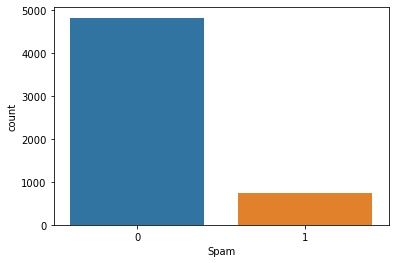

In [6]:
sns.countplot(x='Spam',data=df)

In [7]:
import re
import string
from string import punctuation
from nltk.corpus import stopwords

In [8]:
def text_processing(message):
    
    Stopwords = stopwords.words('english')
    # Check characters to see if they are in punctuation
    no_punctuation = [char for char in message if char not in string.punctuation]

    # Join the characters again to form the string.
    no_punctuation = ''.join(no_punctuation)
    
    # Now just remove any stopwords
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in Stopwords])

In [9]:
df['text'] = df['v2'].apply(text_processing)
df.head()

,v2,Spam,text
0,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...
1,Ok lar... Joking wif u oni...,0,Ok lar Joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,U dun say early hor U c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,Nah dont think goes usf lives around though


# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X=df['text'].values
y=df['Spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Feature Engineering

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [12]:
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

# Build the Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [14]:
X_train.shape

(4457, 8270)

In [15]:
model = Sequential()
model.add(Dense(units=8270,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=400,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [17]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=40,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 4457 samples, validate on 1115 samples
Epoch 1/40
4457/4457 [==============================] - 464s 104ms/sample - loss: 0.2009 - val_loss: 0.1229
Epoch 2/40
4457/4457 [==============================] - 228s 51ms/sample - loss: 0.0391 - val_loss: 0.1071
Epoch 3/40
4457/4457 [==============================] - 129s 29ms/sample - loss: 0.0061 - val_loss: 0.1838
Epoch 4/40
4457/4457 [==============================] - 126s 28ms/sample - loss: 0.0046 - val_loss: 0.2205
Epoch 5/40
4457/4457 [==============================] - 125s 28ms/sample - loss: 1.8889e-04 - val_loss: 0.3160
Epoch 6/40
4457/4457 [==============================] - 125s 28ms/sample - loss: 3.0311e-06 - val_loss: 0.3138
Epoch 7/40
4457/4457 [==============================] - 139s 31ms/sample - loss: 3.7666e-06 - val_loss: 0.3317
Epoch 8/40
4457/4457 [==============================] - 132s 30ms/sample - loss: 9.8613e-05 - val_loss: 0.2950
Epoch 9/40
4457/4457 [==============================] - 117s 26ms/sample - loss

# Evaluation

In [19]:
predictions = model.predict_classes(X_test)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[963   2]
 [ 24 126]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

